<a href="https://colab.research.google.com/github/VijayRaghava25/music-recommendation/blob/main/IDP_(Facial_Emotion_Recognition)_Model_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Desgining the model**

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
dataset = kagglehub.dataset_download('ashishpatel26/facial-expression-recognitionferchallenge')

print('Data source import complete.')

Data source import complete.


In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.0 MB/s eta 0:00:00


In [ ]:
import math
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

In [ ]:
path = os.path.join(dataset, 'fer2013')
# os.listdir(path)
path = os.path.join(path, 'fer2013')
# os.listdir(path)
csv_path = os.path.join(path, 'fer2013.csv')
print(csv_path)

/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv


In [ ]:
df = pd.read_csv(csv_path)
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

<Axes: xlabel='emotion'>

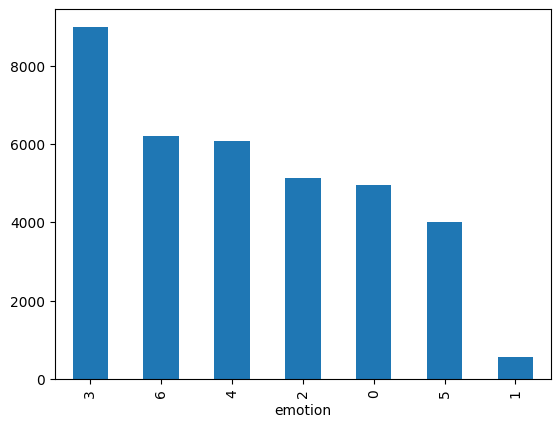

In [ ]:
df.emotion.value_counts().plot(kind='bar')

So the majority classes belong to **3:Happy, 4:Sad, and 6:Neutral** and we are also interested in these three classes only.

In [ ]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

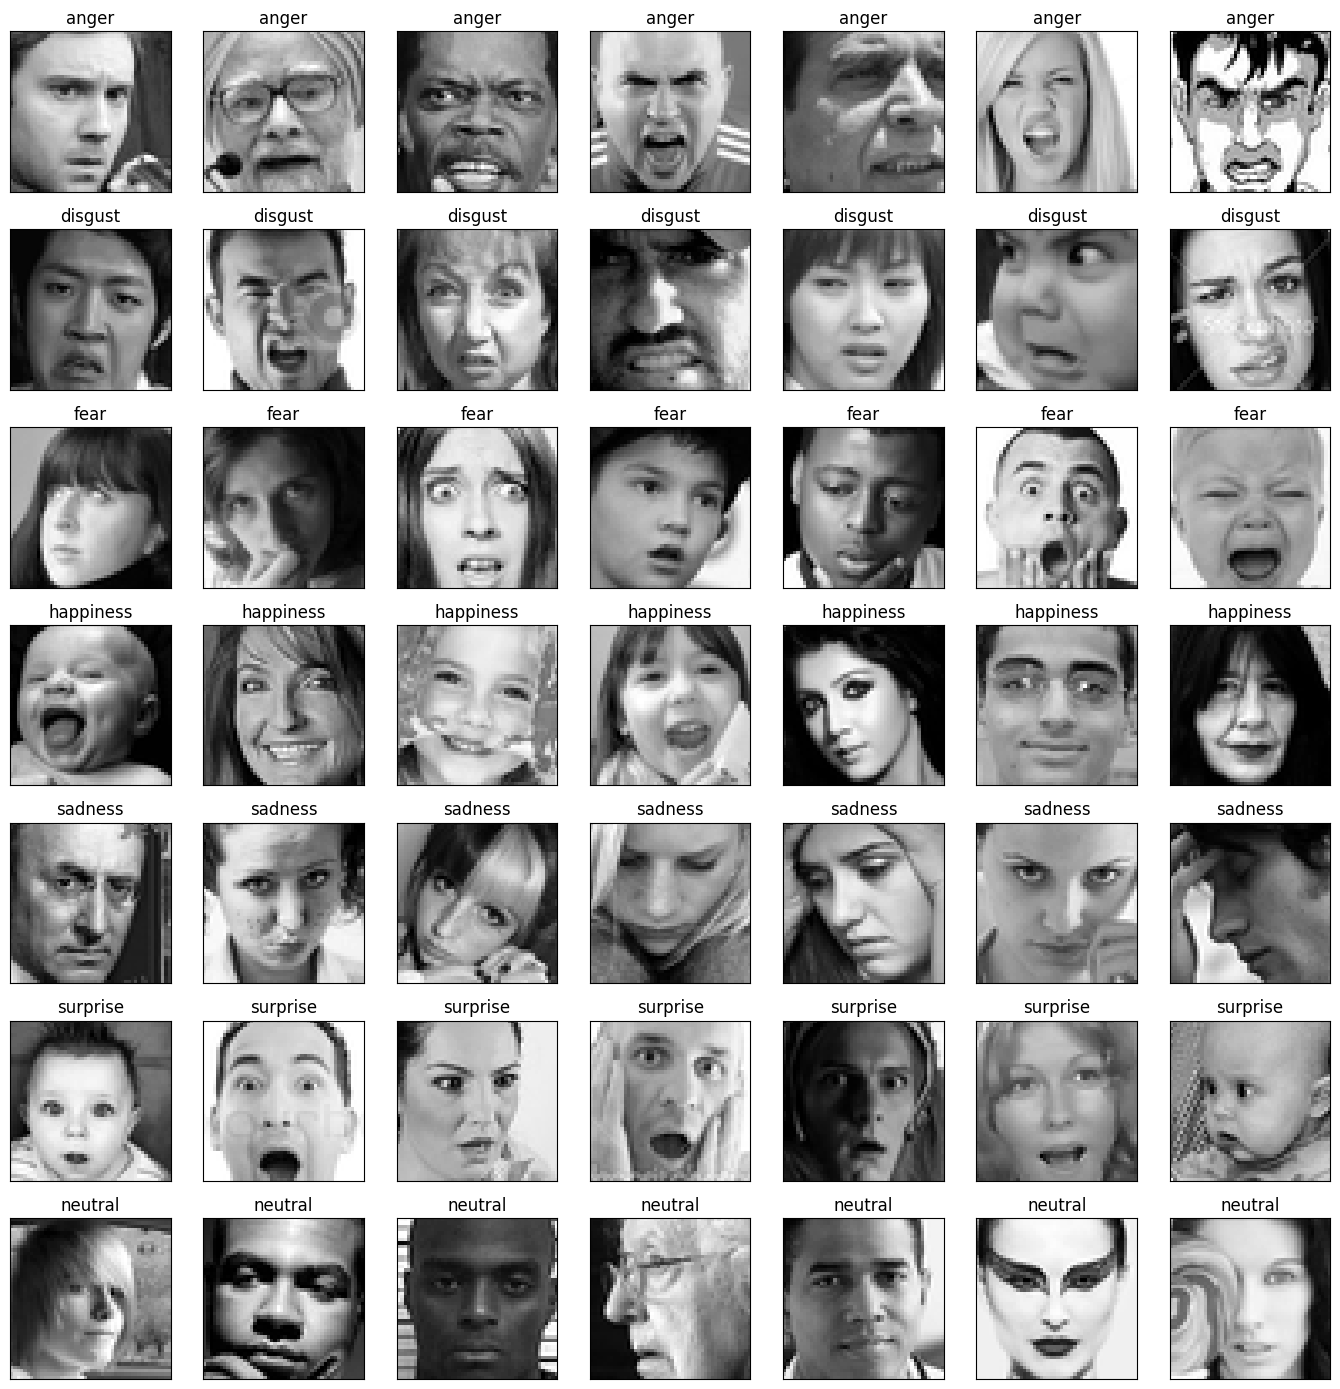

In [ ]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [ ]:
INTERESTED_LABELS = [3, 4, 6]

In [ ]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(21264, 3)

In [ ]:
#making the data Compatible for neural network
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [ ]:
img_array.shape

(21264, 48, 48, 1)

In [ ]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = tf.keras.utils.to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{np.int64(3): np.int64(0), np.int64(4): np.int64(1), np.int64(6): np.int64(2)}


In [ ]:
#splitting the data
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))

In [ ]:
del df
del img_array
del img_labels

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))

    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))

    net.add(Dropout(0.6, name='dropout_4'))

    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )

    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

    net.summary()

    return net

In [ ]:
"""
I used three callbacks one is `early stopping` for avoiding overfitting training data
secong on is `ReduceLROnPlateau` for learning rate and another one is .
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

# mcp = ModelCheckpoint(
#     'best_model1_screach.keras',
#     monitor='val_accuracy',
#     mode='max',
#     verbose=1,
#     save_best_only=True
# )

callbacks = [
    early_stopping,
    lr_scheduler,
    # mcp
]

In [ ]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [ ]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1])
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=int(len(X_train) / batch_size),
    epochs=epochs,
    callbacks=callbacks
)

Model: "DCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_5                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_6                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_7                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,395,075 (9.14 MB)

 Trainable params: 2,393,027 (9.13 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - accuracy: 0.3892 - loss: 1.4979 - val_accuracy: 0.5125 - val_loss: 1.0228 - learning_rate: 0.0010
Epoch 2/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step - accuracy: 0.4062 - loss: 1.1689 - val_accuracy: 0.5092 - val_loss: 1.0303 - learning_rate: 0.0010
Epoch 3/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.4692 - loss: 1.0493 - val_accuracy: 0.5853 - val_loss: 0.8689 - learning_rate: 0.0010
Epoch 4/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5625 - loss: 0.9815 - val_accuracy: 0.5891 - val_loss: 0.8634 - learning_rate: 0.0010
Epoch 5/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5389 - loss: 0.9470 - val_accuracy: 0.6667 - val_loss: 0.7274 - learning_rate: 0.0010
Epoch 6/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 823us/step - accuracy: 0.5312 - loss: 1.1049 - val_accuracy: 0.6648 - val_loss: 0.7272 - learning_rate: 0.0010
Epoch 7/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.606

In [ ]:
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)

# model.save("best_FER_model_screach1.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/IDP/Saved models/FER_Best_Model.h5')

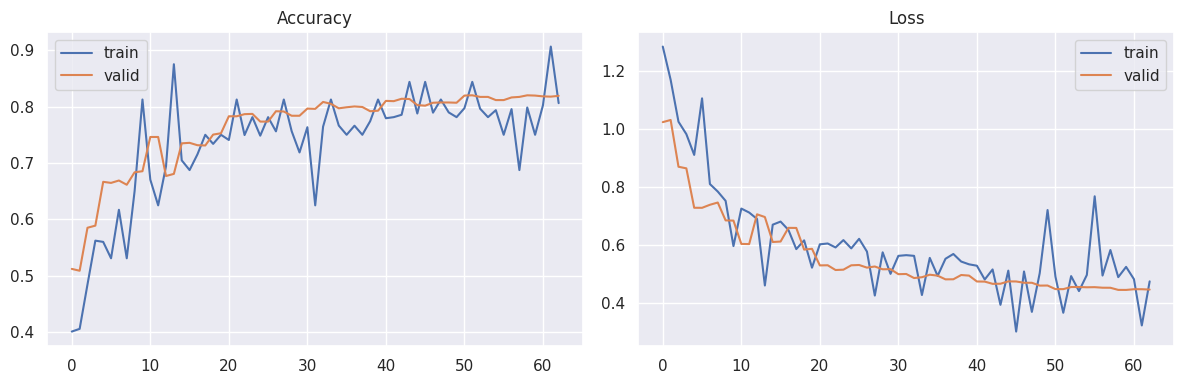

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()


The epochs history shows that accuracy gradually increases and achieved **+80% accuracy** on both training and validation set, but at the end the model starts overfitting training data.

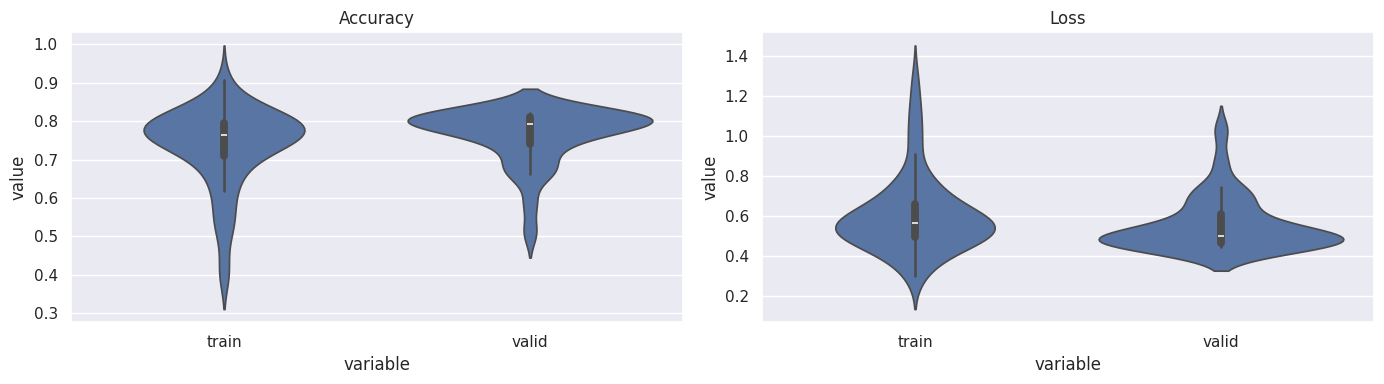

In [ ]:
# Create DataFrames
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

# Plot
fig = pyplot.figure(0, (14, 4))

# Accuracy plot
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu))
pyplot.title('Accuracy')
pyplot.tight_layout()

# Loss plot
ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss))
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


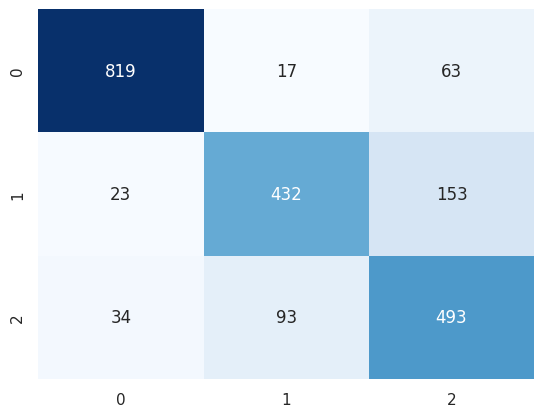

<Figure size 640x480 with 0 Axes>

In [ ]:
yhat_valid = model.predict(X_valid)
yhat_valid_labels = np.argmax(yhat_valid, axis=1)
y_valid_labels = np.argmax(y_valid, axis=1)

# Now compute the confusion matrix
cm = confusion_matrix(y_valid_labels, yhat_valid_labels)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
pyplot.show()

pyplot.savefig("confusion_matrix_dcnn.png")

In [ ]:
yhat_valid_labels = np.argmax(yhat_valid, axis=1)

# Now you can compare the true labels and predicted labels
print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid_labels)}\n\n')

# Print classification report
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid_labels))

total wrong validation predictions: 383


              precision    recall  f1-score   support

           0       0.93      0.91      0.92       899
           1       0.80      0.71      0.75       608
           2       0.70      0.80      0.74       620

    accuracy                           0.82      2127
   macro avg       0.81      0.81      0.81      2127
weighted avg       0.83      0.82      0.82      2127



The confusion matrix clearly shows that our model is doing a **good job on Happy**, but its performance is low in the other two classes. One of the reasons for this is that these two classes have less data. But when I looked at the images I found some photos from these two classes are even hard for a human to tell whether the person is sad or neutral. Facial expression depends on the individual as well. Some people's neutral face looks sad.

In [ ]:
mapper = {
    0: "happy",
    1: "sad",
    2: "neutral",
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


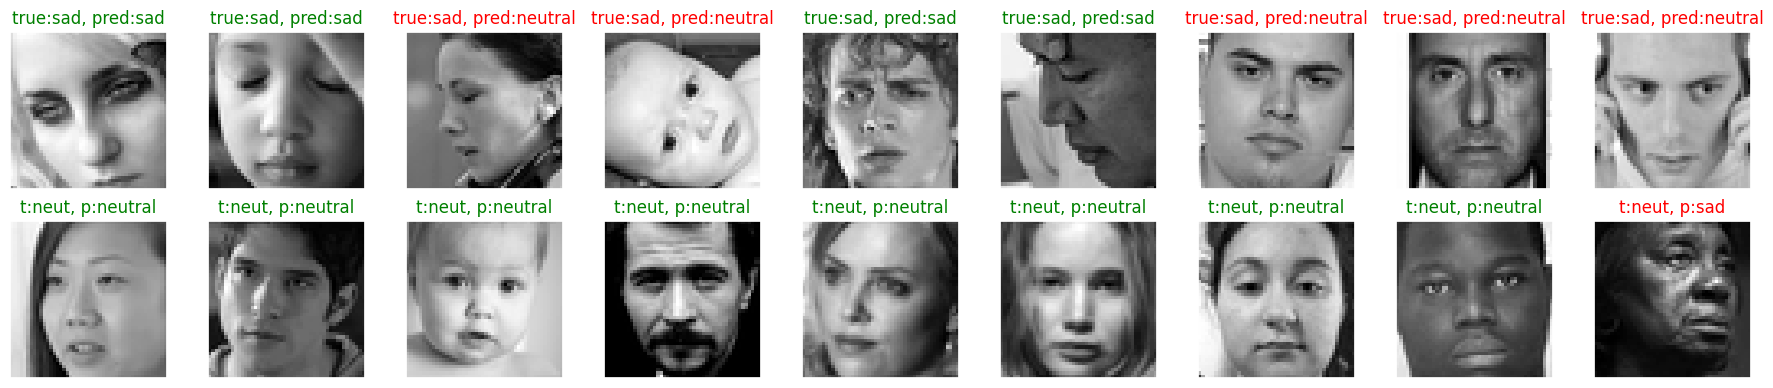

In [ ]:
# Assuming 'mapper' translates numeric labels to class names like 'sad', 'neutral', etc.
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1] == 1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2] == 1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
    # Plot for 'sad' images
    ax = pyplot.subplot(2, 9, i+1)
    sample_img_sad = X_valid[sadidx, :, :, 0]
    pred_sad = np.argmax(model.predict(sample_img_sad.reshape(1, 48, 48, 1)), axis=1)[0]
    true_sad = 1  # True label for 'sad' class (assuming class 1 is 'sad')

    ax.imshow(sample_img_sad, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

    # Set color to green if the prediction is correct, else red
    color_sad = 'green' if pred_sad == true_sad else 'red'
    ax.set_title(f"true:sad, pred:{mapper[pred_sad]}", color=color_sad)

    # Plot for 'neutral' images
    ax = pyplot.subplot(2, 9, i+10)
    sample_img_neutral = X_valid[neuidx, :, :, 0]
    pred_neutral = np.argmax(model.predict(sample_img_neutral.reshape(1, 48, 48, 1)), axis=1)[0]
    true_neutral = 2  # True label for 'neutral' class (assuming class 2 is 'neutral')

    ax.imshow(sample_img_neutral, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

    # Set color to green if the prediction is correct, else red
    color_neutral = 'green' if pred_neutral == true_neutral else 'red'
    ax.set_title(f"t:neut, p:{mapper[pred_neutral]}", color=color_neutral)

pyplot.tight_layout()
pyplot.show()


In the first row, the seventh image appears more neutral than sad, and our model predicted it as neutral. In contrast, the last image in the second row clearly expresses sadness.

# Dealing the loaded model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model("/content/drive/MyDrive/IDP/Saved models/FER_Best_Model.h5")

In [ ]:
|from tensorflow.keras.utils import plot_model

model = build_net(optim='adam')
plot_model(model, to_file='dcnn_model.png', show_shapes=True, show_layer_names=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


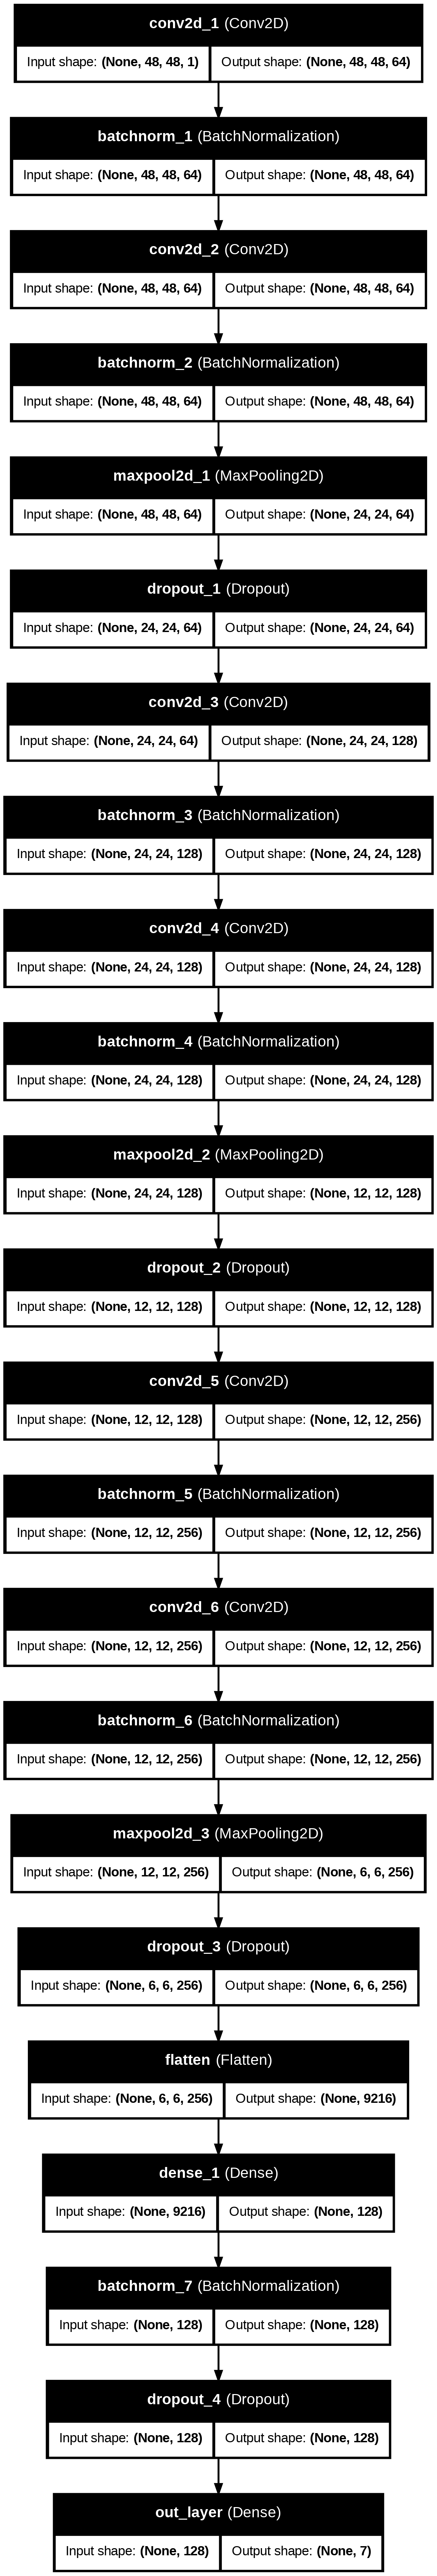

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense

# Define the model again to generate the plot
img_width, img_height, img_depth = 48, 48, 1  # Assuming typical settings for something like FER-2013 dataset
num_classes = 7  # Example for emotion classification

def build_net(optim='adam'):
    net = Sequential(name='DCNN')

    net.add(Conv2D(64, (5,5), input_shape=(img_width, img_height, img_depth),
                   activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_1'))
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(Conv2D(64, (5,5), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_2'))
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(Conv2D(128, (3,3), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_3'))
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(Conv2D(128, (3,3), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_4'))
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(Conv2D(256, (3,3), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_5'))
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(Conv2D(256, (3,3), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_6'))
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))

    net.add(Dense(128, activation='elu', kernel_initializer='he_normal', name='dense_1'))
    net.add(BatchNormalization(name='batchnorm_7'))
    net.add(Dropout(0.6, name='dropout_4'))

    net.add(Dense(num_classes, activation='softmax', name='out_layer'))

    net.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

    return net

model = build_net()

# Generate the plot of the model
plot_model(model, to_file='/content/drive/MyDrive/IDP/Saved models/dcnn_model_image.png', show_shapes=True, show_layer_names=True)